In [1]:
from huggingface_hub import snapshot_download
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, TaskType
import torch
import numpy as np
from trl import RewardTrainer, RewardConfig
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
from data_preprocess import process_pairs_dataset
from training.reward_trainer import DistributionRewardTrainer
from training.train_utils import expectation
from config import MODEL_PATH, N_SCORES, DATA_PATH, SEED, DISTRIBUTION_REWARD_MODEL_PATH

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
REPO = "HuggingFaceTB/SmolLM2-135M-Instruct"
snapshot_download(repo_id=REPO, local_dir="./model")

In [7]:
reward_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=N_SCORES,
    local_files_only=True
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, use_fast=True)
reward_model.config.pad_token_id = reward_model.config.eos_token_id

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at ./model and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
train_data = load_dataset(DATA_PATH, split="train")
val_data = load_dataset(DATA_PATH, split="validation")

train_data = process_pairs_dataset(train_data)
val_data = process_pairs_dataset(val_data)

In [10]:
training_args = RewardConfig(
    output_dir="./reward_model_distribution",
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    learning_rate=5e-5,
    num_train_epochs=1,
    logging_strategy="steps",
    logging_steps=300,
    eval_strategy="steps",
    eval_steps=300,
    save_steps=300,
    fp16=True,
    load_best_model_at_end=True,
    report_to="none",
)

trainer = DistributionRewardTrainer(
    model=reward_model,
    processing_class=tokenizer,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
)

In [11]:
trainer.train()

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
300,1.188300,1.151864,0.543284
600,1.135500,1.174551,0.558209
900,1.117500,1.132176,0.561194
1200,1.091100,1.130394,0.582090


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>system                            │ <|im_start|>system                           │ [0.1693, 0.8307] │
│ You are a helpful AI assistant named SmolLM,  │ You are a helpful AI assistant named SmolLM, │                  │
│ trained by Hugging Face                       │ trained by Hugging Face                      │                  │
│ <|im_start|>user                              │ <|im_start|>user                             │                  │
│                                               │                                              │                  │
│  Is it possible to host data on a satellite?  │  Is it possible to host data on a satellite? │                  │
│ <extra_id_1>Assistant                         │ <extra_id_1>Assistant                        │                  │
│ Yes, it’s possible to host data on a          │ Yes, it’s possible to host data on a         │                  │
│ satellite. Satellites can carry computer      │ satellite. Satellites can carry computer     │                  │
│ servers and other electronic equipment, so    │ servers and other electronic equipment, so   │                  │
│ it’s possible to store and transmit data via  │ it’s possible to store and transmit data via │                  │
│ satellite. This is often used for remote data │ satellite. This is often used for remote     │                  │
│ storage and backup, as well as for internet   │ data storage and backup, as well as for      │                  │
│ and telecommunications services.              │ internet and telecommunications services.    │                  │
│ Satellite-hosted data is relatively secure,   │ Satellite-hosted data is relatively secure,  │                  │
│ as it’s not vulnerable to terrestrial threats │ as it’s not vulnerable to terrestrial        │                  │
│ like natural disasters or hacking, and it can │ threats like natural disasters or hacking,   │                  │
│ be accessed from anywhere on the globe.       │ and it can be accessed from anywhere on the  │                  │
│ <extra_id_1>User                              │ globe.                                       │                  │
│ Does hosting data on a satellite ensure that  │ <extra_id_1>User                             │                  │
│ governments and corporations will be unable   │ Does hosting data on a satellite ensure that │                  │
│ to acess the servers?                         │ governments and corporations will be unable  │                  │
│ <extra_id_1>Assistant                         │ to acess the servers?                        │                  │
│ Hosting data on a satellite does help ensure  │ <extra_id_1>Assistant                        │                  │
│ privacy and security, as satellite data       │ Hosting data on a satellite does help ensure │                  │
│ hosting services are often located in         │ privacy and security, as satellite data      │                  │
│ jurisdictions with strong privacy laws, and   │ hosting services are often located in        │                  │
│ are physically isolated from terrestrial      │ jurisdictions with strong privacy laws, and  │                  │
│ threats like hacking and natural disasters.   │ are physically isolated from terrestrial     │                  │
│ However, there is still some risk of          │ threats like hacking and natural disasters.  │                  │
│ unauthorized access to satellite-hosted data, │ However, there is still some risk of         │                  │
│ as satellites are vulnerable to attack from   │ unauth

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>system                            │ <|im_start|>system                           │ [0.5006, 0.4994] │
│ You are a helpful AI assistant named SmolLM,  │ You are a helpful AI assistant named SmolLM, │                  │
│ trained by Hugging Face                       │ trained by Hugging Face                      │                  │
│ <|im_start|>user                              │ <|im_start|>user                             │                  │
│                                               │                                              │                  │
│  Is it possible to host data on a satellite?  │  Is it possible to host data on a satellite? │                  │
│ <extra_id_1>Assistant                         │ <extra_id_1>Assistant                        │                  │
│ Yes, it’s possible to host data on a          │ Yes, it’s possible to host data on a         │                  │
│ satellite. Satellites can carry computer      │ satellite. Satellites can carry computer     │                  │
│ servers and other electronic equipment, so    │ servers and other electronic equipment, so   │                  │
│ it’s possible to store and transmit data via  │ it’s possible to store and transmit data via │                  │
│ satellite. This is often used for remote data │ satellite. This is often used for remote     │                  │
│ storage and backup, as well as for internet   │ data storage and backup, as well as for      │                  │
│ and telecommunications services.              │ internet and telecommunications services.    │                  │
│ Satellite-hosted data is relatively secure,   │ Satellite-hosted data is relatively secure,  │                  │
│ as it’s not vulnerable to terrestrial threats │ as it’s not vulnerable to terrestrial        │                  │
│ like natural disasters or hacking, and it can │ threats like natural disasters or hacking,   │                  │
│ be accessed from anywhere on the globe.       │ and it can be accessed from anywhere on the  │                  │
│ <extra_id_1>User                              │ globe.                                       │                  │
│ Does hosting data on a satellite ensure that  │ <extra_id_1>User                             │                  │
│ governments and corporations will be unable   │ Does hosting data on a satellite ensure that │                  │
│ to acess the servers?                         │ governments and corporations will be unable  │                  │
│ <extra_id_1>Assistant                         │ to acess the servers?                        │                  │
│ Hosting data on a satellite does help ensure  │ <extra_id_1>Assistant                        │                  │
│ privacy and security, as satellite data       │ Hosting data on a satellite does help ensure │                  │
│ hosting services are often located in         │ privacy and security, as satellite data      │                  │
│ jurisdictions with strong privacy laws, and   │ hosting services are often located in        │                  │
│ are physically isolated from terrestrial      │ jurisdictions with strong privacy laws, and  │                  │
│ threats like hacking and natural disasters.   │ are physically isolated from terrestrial     │                  │
│ However, there is still some risk of          │ threats like hacking and natural disasters.  │                  │
│ unauthorized access to satellite-hosted data, │ However, there is still some risk of         │                  │
│ as satellites are vulnerable to attack from   │ unauth

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>system                            │ <|im_start|>system                           │ [0.2466, 0.7534] │
│ You are a helpful AI assistant named SmolLM,  │ You are a helpful AI assistant named SmolLM, │                  │
│ trained by Hugging Face                       │ trained by Hugging Face                      │                  │
│ <|im_start|>user                              │ <|im_start|>user                             │                  │
│                                               │                                              │                  │
│  Is it possible to host data on a satellite?  │  Is it possible to host data on a satellite? │                  │
│ <extra_id_1>Assistant                         │ <extra_id_1>Assistant                        │                  │
│ Yes, it’s possible to host data on a          │ Yes, it’s possible to host data on a         │                  │
│ satellite. Satellites can carry computer      │ satellite. Satellites can carry computer     │                  │
│ servers and other electronic equipment, so    │ servers and other electronic equipment, so   │                  │
│ it’s possible to store and transmit data via  │ it’s possible to store and transmit data via │                  │
│ satellite. This is often used for remote data │ satellite. This is often used for remote     │                  │
│ storage and backup, as well as for internet   │ data storage and backup, as well as for      │                  │
│ and telecommunications services.              │ internet and telecommunications services.    │                  │
│ Satellite-hosted data is relatively secure,   │ Satellite-hosted data is relatively secure,  │                  │
│ as it’s not vulnerable to terrestrial threats │ as it’s not vulnerable to terrestrial        │                  │
│ like natural disasters or hacking, and it can │ threats like natural disasters or hacking,   │                  │
│ be accessed from anywhere on the globe.       │ and it can be accessed from anywhere on the  │                  │
│ <extra_id_1>User                              │ globe.                                       │                  │
│ Does hosting data on a satellite ensure that  │ <extra_id_1>User                             │                  │
│ governments and corporations will be unable   │ Does hosting data on a satellite ensure that │                  │
│ to acess the servers?                         │ governments and corporations will be unable  │                  │
│ <extra_id_1>Assistant                         │ to acess the servers?                        │                  │
│ Hosting data on a satellite does help ensure  │ <extra_id_1>Assistant                        │                  │
│ privacy and security, as satellite data       │ Hosting data on a satellite does help ensure │                  │
│ hosting services are often located in         │ privacy and security, as satellite data      │                  │
│ jurisdictions with strong privacy laws, and   │ hosting services are often located in        │                  │
│ are physically isolated from terrestrial      │ jurisdictions with strong privacy laws, and  │                  │
│ threats like hacking and natural disasters.   │ are physically isolated from terrestrial     │                  │
│ However, there is still some risk of          │ threats like hacking and natural disasters.  │                  │
│ unauthorized access to satellite-hosted data, │ However, there is still some risk of         │                  │
│ as satellites are vulnerable to attack from   │ unauth

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>system                            │ <|im_start|>system                           │ [0.2867, 0.7133] │
│ You are a helpful AI assistant named SmolLM,  │ You are a helpful AI assistant named SmolLM, │                  │
│ trained by Hugging Face                       │ trained by Hugging Face                      │                  │
│ <|im_start|>user                              │ <|im_start|>user                             │                  │
│                                               │                                              │                  │
│  Is it possible to host data on a satellite?  │  Is it possible to host data on a satellite? │                  │
│ <extra_id_1>Assistant                         │ <extra_id_1>Assistant                        │                  │
│ Yes, it’s possible to host data on a          │ Yes, it’s possible to host data on a         │                  │
│ satellite. Satellites can carry computer      │ satellite. Satellites can carry computer     │                  │
│ servers and other electronic equipment, so    │ servers and other electronic equipment, so   │                  │
│ it’s possible to store and transmit data via  │ it’s possible to store and transmit data via │                  │
│ satellite. This is often used for remote data │ satellite. This is often used for remote     │                  │
│ storage and backup, as well as for internet   │ data storage and backup, as well as for      │                  │
│ and telecommunications services.              │ internet and telecommunications services.    │                  │
│ Satellite-hosted data is relatively secure,   │ Satellite-hosted data is relatively secure,  │                  │
│ as it’s not vulnerable to terrestrial threats │ as it’s not vulnerable to terrestrial        │                  │
│ like natural disasters or hacking, and it can │ threats like natural disasters or hacking,   │                  │
│ be accessed from anywhere on the globe.       │ and it can be accessed from anywhere on the  │                  │
│ <extra_id_1>User                              │ globe.                                       │                  │
│ Does hosting data on a satellite ensure that  │ <extra_id_1>User                             │                  │
│ governments and corporations will be unable   │ Does hosting data on a satellite ensure that │                  │
│ to acess the servers?                         │ governments and corporations will be unable  │                  │
│ <extra_id_1>Assistant                         │ to acess the servers?                        │                  │
│ Hosting data on a satellite does help ensure  │ <extra_id_1>Assistant                        │                  │
│ privacy and security, as satellite data       │ Hosting data on a satellite does help ensure │                  │
│ hosting services are often located in         │ privacy and security, as satellite data      │                  │
│ jurisdictions with strong privacy laws, and   │ hosting services are often located in        │                  │
│ are physically isolated from terrestrial      │ jurisdictions with strong privacy laws, and  │                  │
│ threats like hacking and natural disasters.   │ are physically isolated from terrestrial     │                  │
│ However, there is still some risk of          │ threats like hacking and natural disasters.  │                  │
│ unauthorized access to satellite-hosted data, │ However, there is still some risk of         │                  │
│ as satellites are vulnerable to attack from   │ unauth

TrainOutput(global_step=1204, training_loss=1.1330058954878899, metrics={'train_runtime': 540.7111, 'train_samples_per_second': 13.36, 'train_steps_per_second': 2.227, 'total_flos': 0.0, 'train_loss': 1.1330058954878899, 'epoch': 1.0})

In [14]:
trainer.save_model(DISTRIBUTION_REWARD_MODEL_PATH)

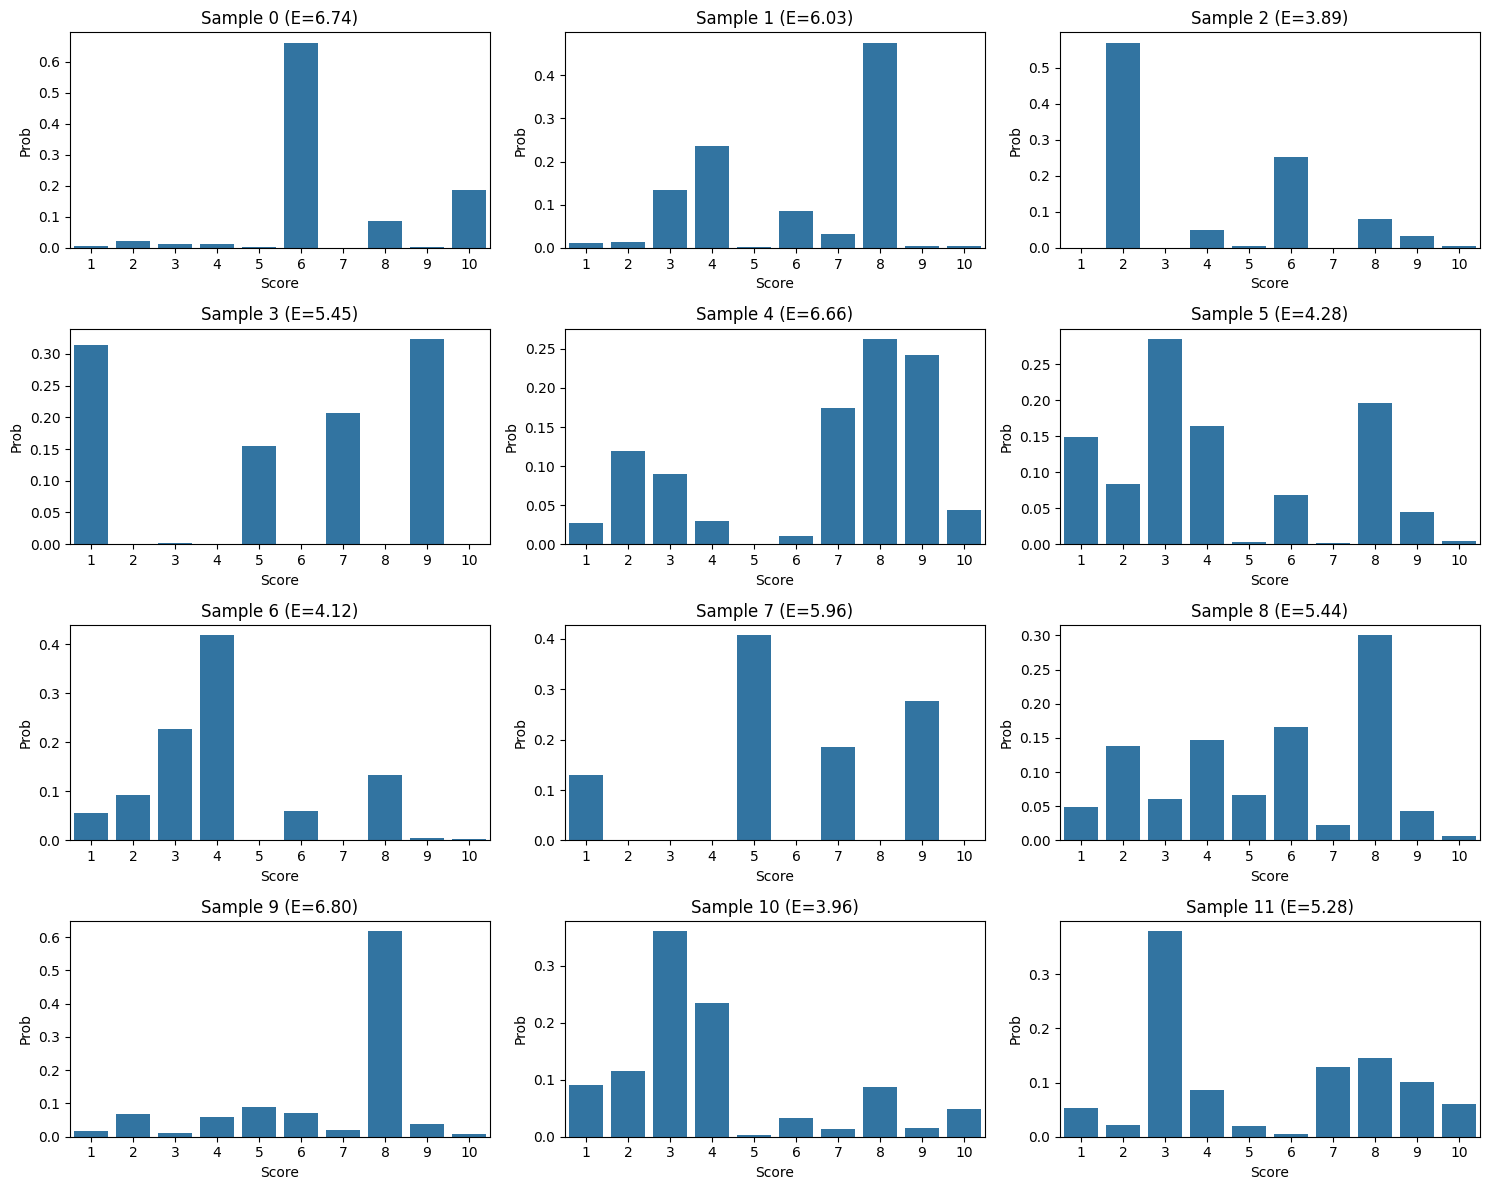

In [12]:
n_samples=12
fig, axes = plt.subplots(4, 3, figsize=(15, 12))  # 4 строки × 3 столбца = 12 графиков
axes = axes.flatten()

for i in range(n_samples):
    sample = train_data[i]
    input_ids = torch.tensor(sample["input_ids_chosen"], device=device).unsqueeze(0)
    attention_mask = torch.tensor(sample["attention_mask_chosen"], device=device).unsqueeze(0)

    with torch.no_grad():
        logits = reward_model(input_ids, attention_mask).logits  # shape: (1, n_scores)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        expect = expectation(logits).item()

    ax = axes[i]
    sns.barplot(x=list(range(1, len(probs) + 1)), y=probs, ax=ax)
    ax.set_title(f"Sample {i} (E={expect:.2f})")
    ax.set_xlabel("Score")
    ax.set_ylabel("Prob")

for j in range(n_samples, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


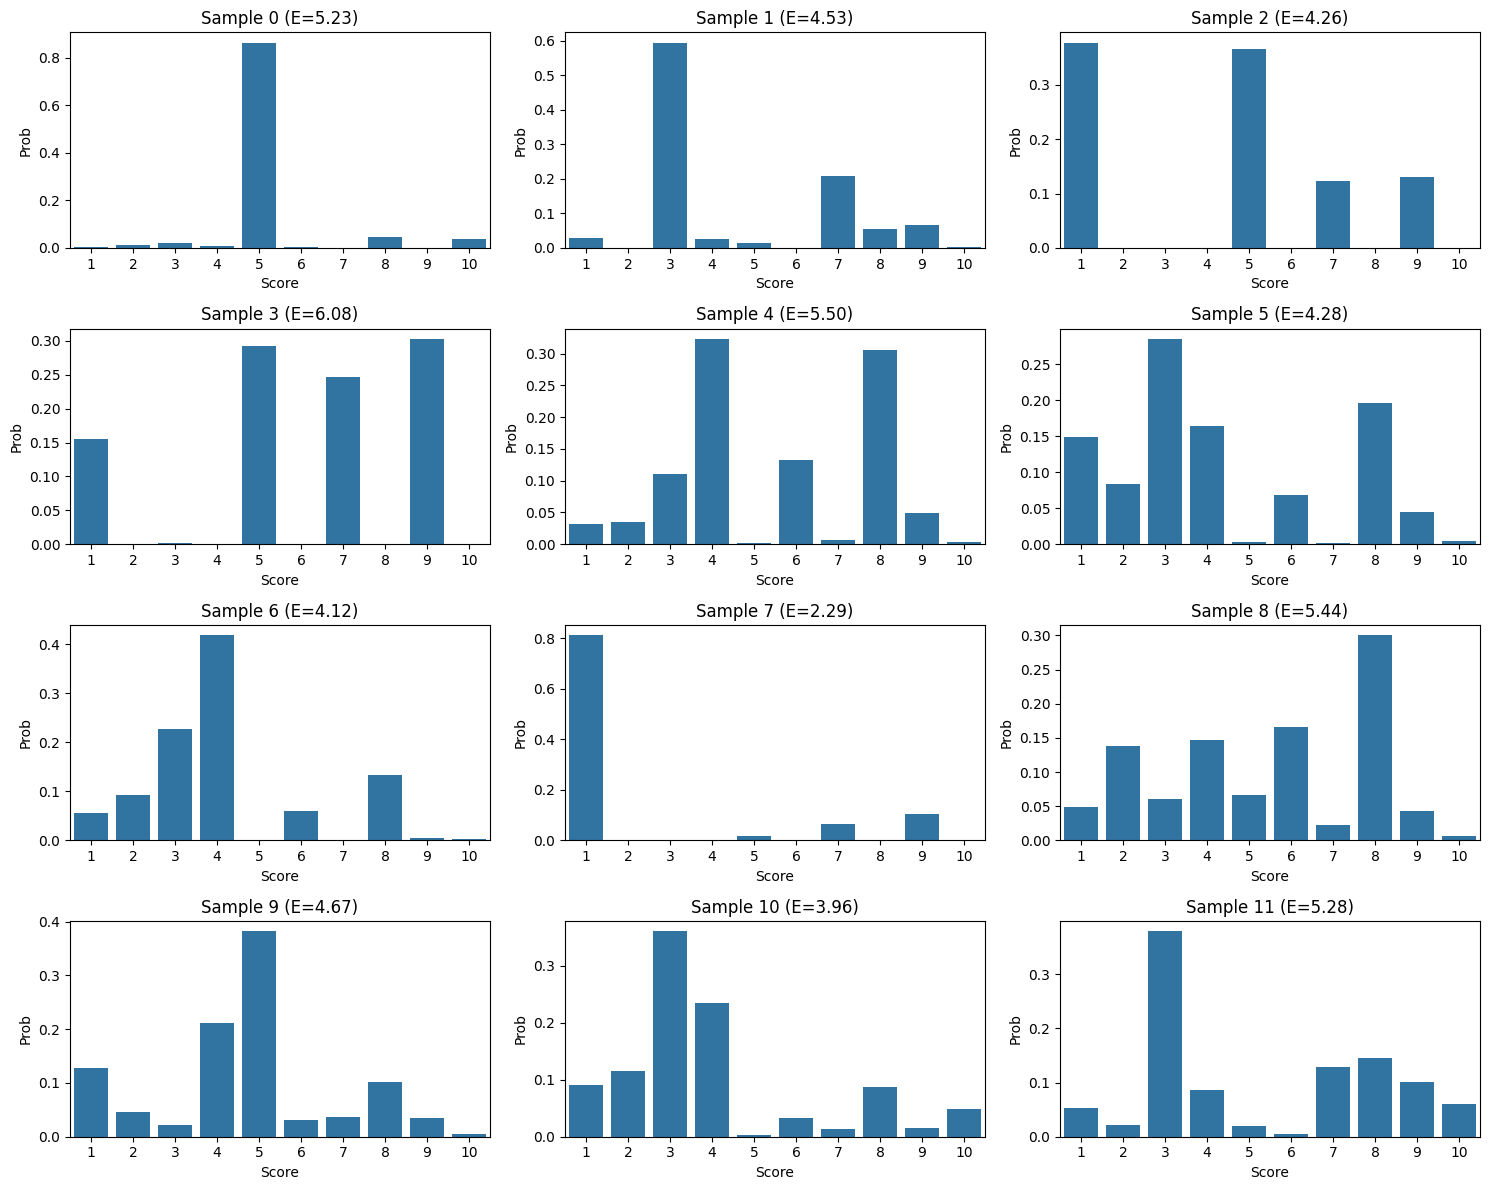

In [13]:
n_samples=12
fig, axes = plt.subplots(4, 3, figsize=(15, 12))  # 4 строки × 3 столбца = 12 графиков
axes = axes.flatten()

for i in range(n_samples):
    sample = train_data[i]
    input_ids = torch.tensor(sample["input_ids_rejected"], device=device).unsqueeze(0)
    attention_mask = torch.tensor(sample["attention_mask_rejected"], device=device).unsqueeze(0)

    with torch.no_grad():
        logits = reward_model(input_ids, attention_mask).logits  # shape: (1, n_scores)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        expect = expectation(logits).item()

    ax = axes[i]
    sns.barplot(x=list(range(1, len(probs) + 1)), y=probs, ax=ax)
    ax.set_title(f"Sample {i} (E={expect:.2f})")
    ax.set_xlabel("Score")
    ax.set_ylabel("Prob")

for j in range(n_samples, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
